<a href="https://colab.research.google.com/github/sachsac/Im-Going-to-Disney-World/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and upload data

In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

[My Cleaning Steps and EDA Notebook](https://colab.research.google.com/drive/14kr6L5CFFWyLyjZBRZDqr8q_9YZMKhV9?usp=sharing)

In [233]:
df = pd.read_csv('https://raw.githubusercontent.com/sachsac/Im-Going-to-Disney-World/main/WDW_Cleaned.csv') #Cleaned data from original
df.head()

,Ride_name,Park_location,Park_area,Ride_type_all,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Age_interest_all,Age_interest_preschoolers,Age_interest_tweens,Age_interest_teens,Age_interest_adults,Height_req_inches,Ride_duration_min,Age_of_ride_years,TL_rank,TA_Stars
0,Alien Swirling Saucers,HS,Toy Story Land,spinning,0,1,0,0,0,0,0,0,1,0,all ages,1,1,1,1,32,1.5,4.314168,31,4.0
1,Astro Orbiter,MK,Tomorrowland,"spinning, slow",0,1,1,0,0,0,0,0,0,1,all ages,1,1,1,1,0,1.5,27.657084,43,3.5
2,Avatar Flight of Passage,AK,Pandora,thrill,1,0,0,0,0,0,0,0,1,0,"kids, tweens, teens, adults",0,1,1,1,44,5.0,5.406571,9,5.0
3,Big Thunder Mountain Railroad,MK,Frontierland,"thrill, small drops",1,0,0,1,0,0,0,0,1,1,"kids, tweens, teens, adults",0,1,1,1,40,3.5,42.080082,8,4.5
4,Buzz Lightyear's Space Ranger Spin,MK,Tomorrowland,"spinning, slow",0,1,1,0,0,0,0,0,1,0,all ages,1,1,1,1,0,4.0,24.043121,32,4.5


In [234]:
#df with age interests removed from last step
no_ages_df = pd.read_csv('https://raw.githubusercontent.com/sachsac/Im-Going-to-Disney-World/main/WDW_no_ages.csv')
no_ages_df.head()

,Ride_name,Park_location,Park_area,Ride_type_all,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Height_req_inches,Ride_duration_min,Age_of_ride_years,TL_rank,TA_Stars
0,Alien Swirling Saucers,HS,Toy Story Land,spinning,0,1,0,0,0,0,0,0,1,0,32,1.5,4.314168,31,4.0
1,Astro Orbiter,MK,Tomorrowland,"spinning, slow",0,1,1,0,0,0,0,0,0,1,0,1.5,27.657084,43,3.5
2,Avatar Flight of Passage,AK,Pandora,thrill,1,0,0,0,0,0,0,0,1,0,44,5.0,5.406571,9,5.0
3,Big Thunder Mountain Railroad,MK,Frontierland,"thrill, small drops",1,0,0,1,0,0,0,0,1,1,40,3.5,42.080082,8,4.5
4,Buzz Lightyear's Space Ranger Spin,MK,Tomorrowland,"spinning, slow",0,1,1,0,0,0,0,0,1,0,0,4.0,24.043121,32,4.5


# Model Preprocessing

## Change Index and Drop Unnecessary Columns
Since Ride_type_all and age_interest_all are repetitive, I will NOT dummies them. They will be dropped out of the models. I will also choose to make the ride names the index.

Lastly, if we are trying to determine what makes a ride enjoyable for future rides, we will want to drop our 'TL_rank' column as well.

In [235]:
df = df.set_index('Ride_name').drop(columns = ['Ride_type_all', 'Age_interest_all', 'TL_rank'])
no_ages_df = no_ages_df.set_index('Ride_name').drop(columns = ['Ride_type_all', 'TL_rank'])

In [236]:
df.head()

,Park_location,Park_area,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Age_interest_preschoolers,Age_interest_tweens,Age_interest_teens,Age_interest_adults,Height_req_inches,Ride_duration_min,Age_of_ride_years,TA_Stars
Ride_name,,,,,,,,,,,,,,,,,,,,
Alien Swirling Saucers,HS,Toy Story Land,0,1,0,0,0,0,0,0,1,0,1,1,1,1,32,1.5,4.314168,4.0
Astro Orbiter,MK,Tomorrowland,0,1,1,0,0,0,0,0,0,1,1,1,1,1,0,1.5,27.657084,3.5
Avatar Flight of Passage,AK,Pandora,1,0,0,0,0,0,0,0,1,0,0,1,1,1,44,5.0,5.406571,5.0
Big Thunder Mountain Railroad,MK,Frontierland,1,0,0,1,0,0,0,0,1,1,0,1,1,1,40,3.5,42.080082,4.5
Buzz Lightyear's Space Ranger Spin,MK,Tomorrowland,0,1,1,0,0,0,0,0,1,0,1,1,1,1,0,4.0,24.043121,4.5


In [237]:
no_ages_df.head()

,Park_location,Park_area,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Height_req_inches,Ride_duration_min,Age_of_ride_years,TA_Stars
Ride_name,,,,,,,,,,,,,,,,
Alien Swirling Saucers,HS,Toy Story Land,0,1,0,0,0,0,0,0,1,0,32,1.5,4.314168,4.0
Astro Orbiter,MK,Tomorrowland,0,1,1,0,0,0,0,0,0,1,0,1.5,27.657084,3.5
Avatar Flight of Passage,AK,Pandora,1,0,0,0,0,0,0,0,1,0,44,5.0,5.406571,5.0
Big Thunder Mountain Railroad,MK,Frontierland,1,0,0,1,0,0,0,0,1,1,40,3.5,42.080082,4.5
Buzz Lightyear's Space Ranger Spin,MK,Tomorrowland,0,1,1,0,0,0,0,0,1,0,0,4.0,24.043121,4.5


## Get Dummies
The categorical columns we will want to make into dummied columns are park_location and park_area, our last remaining object columns.

In [238]:
no_ages_df = pd.get_dummies(no_ages_df, columns = ['Park_location', 'Park_area'], drop_first = False) #I choose not to drop first because of later steps where I will be dropping some of the area columns; I do not want to lose a possibly more important column by it being "first"
df = pd.get_dummies(df, columns = ['Park_location', 'Park_area'], drop_first = False)

In [239]:
no_ages_df.head()

,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Height_req_inches,Ride_duration_min,Age_of_ride_years,TA_Stars,Park_location_AK,Park_location_EC,Park_location_HS,Park_location_MK,Park_area_Adventureland,Park_area_Africa,Park_area_Asia,Park_area_Dinoland USA,Park_area_Echo Lake,Park_area_Fantasyland,Park_area_Frontierland,Park_area_Future World,Park_area_Liberty Square,Park_area_Main Street USA,Park_area_Pandora,Park_area_Sunset Boulevard,Park_area_Tomorrowland,Park_area_Toy Story Land,Park_area_World Showcase
Ride_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alien Swirling Saucers,0,1,0,0,0,0,0,0,1,0,32,1.5,4.314168,4.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Astro Orbiter,0,1,1,0,0,0,0,0,0,1,0,1.5,27.657084,3.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Avatar Flight of Passage,1,0,0,0,0,0,0,0,1,0,44,5.0,5.406571,5.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Big Thunder Mountain Railroad,1,0,0,1,0,0,0,0,1,1,40,3.5,42.080082,4.5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Buzz Lightyear's Space Ranger Spin,0,1,1,0,0,0,0,0,1,0,0,4.0,24.043121,4.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [240]:
no_ages_df.shape

(44, 33)

## Change Target column to string

What if we change the Star ratings into a binary with "High" and "Low" Stars?

In [241]:
print('Distributions')
print(df['TA_Stars'].describe())
print('_______________________________')
print('Value Counts')
print(df['TA_Stars'].value_counts())

Distributions
count    44.000000
mean      4.227273
std       0.437415
min       3.000000
25%       4.000000
50%       4.250000
75%       4.500000
max       5.000000
Name: TA_Stars, dtype: float64
_______________________________
Value Counts
4.5    18
4.0    17
5.0     4
3.5     4
3.0     1
Name: TA_Stars, dtype: int64


My thoughts are, have 4.5 and 5 as high (1/positive class), 4 and below as low (0/negative class) since 4 is under the mean.

In [242]:
df['TA_Stars'] = df['TA_Stars'].replace({5.0: 1, 4.5: 1, 4.0: 0, 3.5: 0, 3.0: 0})
df['TA_Stars'].value_counts() #perfect split!!

1.0    22
0.0    22
Name: TA_Stars, dtype: int64

In [243]:
#do the same for our no_ages_df
no_ages_df['TA_Stars'] = no_ages_df['TA_Stars'].replace({5.0: 1, 4.5: 1, 4.0: 0, 3.5: 0, 3.0: 0})
no_ages_df['TA_Stars'].value_counts() 

1.0    22
0.0    22
Name: TA_Stars, dtype: int64

We now half a perfectly balanced model!

In [244]:
#change them into integers rather than floats
df['TA_Stars'] = df['TA_Stars'].astype(int)
no_ages_df['TA_Stars'] = no_ages_df['TA_Stars'].astype(int)
print('DF:', df['TA_Stars'].dtypes)
print('No_ages:', no_ages_df['TA_Stars'].dtypes)

DF: int64
No_ages: int64


# No Age Interests DF

## ML Model

In [245]:
no_ages_df['TA_Stars'].value_counts() # it should be the same as other df

1    22
0    22
Name: TA_Stars, dtype: int64

In [246]:
X = no_ages_df.drop(columns= 'TA_Stars')
y = no_ages_df['TA_Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
#chose to change the test size to 33% rather than 25% due to the size and distribution of the data

In [247]:
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))

Counts of each class in Training: {0: 14, 1: 15}
Counts of each class in Test: {0: 8, 1: 7}


In [248]:
#Baseline accuracy: the accuracy to beat!
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True)) #slightly skewed to high stars
print('---------------------------')
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True))  #slight skewed to low stars)

Baseline Training Accuracy:
1    0.517241
0    0.482759
Name: TA_Stars, dtype: float64
---------------------------
Baseline Testing Accuracy:
0    0.533333
1    0.466667
Name: TA_Stars, dtype: float64


In [249]:
%%time
#this is where things may change!
rf = RandomForestClassifier(random_state=42)
no_ages_rfpipe = make_pipeline(rf) #doesnt need scaler
no_ages_rfpipe.fit(X_train, y_train)

knn = KNeighborsClassifier()
no_ages_knnpipe = make_pipeline(StandardScaler(), knn)
no_ages_knnpipe.fit(X_train, y_train)

no_ages_xgb = make_pipeline(StandardScaler(), XGBClassifier())
no_ages_xgb.fit(X_train, y_train)

no_ages_lgb = make_pipeline(StandardScaler(), LGBMClassifier())
no_ages_lgb.fit(X_train, y_train)

no_ages_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier())
no_ages_gbc.fit(X_train, y_train)

lr = LogisticRegression(random_state=42) #we have a binary so logistic regression may be useful
no_ages_lrpipe = make_pipeline(StandardScaler(), lr)
no_ages_lrpipe.fit(X_train, y_train)


print('Random Forest Train Accuracy:', no_ages_rfpipe.score(X_train, y_train))
print('Random ForestTest Accuracy:', no_ages_rfpipe.score(X_test, y_test))
print('____________________________________')
print('KNN Train Accuracy:', no_ages_knnpipe.score(X_train, y_train))
print('KNN Test Accuracy:', no_ages_knnpipe.score(X_test, y_test))
print('____________________________________')
print('XGB Training accuracy:', no_ages_xgb.score(X_train, y_train))
print('XGB Testing accuracy:', no_ages_xgb.score(X_test, y_test))
print('____________________________________')
print('LGB Regression Train Accuracy:', no_ages_lgb.score(X_train, y_train))
print('LGB Regression Test Accuracy:', no_ages_lgb.score(X_test, y_test))
print('____________________________________')
print('GBC Regression Train Accuracy:', no_ages_gbc.score(X_train, y_train))
print('GBC Regression Test Accuracy:', no_ages_gbc.score(X_test, y_test))
print('____________________________________')
print('Logistic Regression Train Accuracy:', no_ages_lrpipe.score(X_train, y_train))
print('Logistic Regression Test Accuracy:', no_ages_lrpipe.score(X_test, y_test))

Random Forest Train Accuracy: 1.0
Random ForestTest Accuracy: 0.6666666666666666
____________________________________
KNN Train Accuracy: 0.6551724137931034
KNN Test Accuracy: 0.6666666666666666
____________________________________
XGB Training accuracy: 0.9310344827586207
XGB Testing accuracy: 0.6666666666666666
____________________________________
LGB Regression Train Accuracy: 0.5172413793103449
LGB Regression Test Accuracy: 0.4666666666666667
____________________________________
GBC Regression Train Accuracy: 1.0
GBC Regression Test Accuracy: 0.6
____________________________________
Logistic Regression Train Accuracy: 0.9310344827586207
Logistic Regression Test Accuracy: 0.6666666666666666
CPU times: user 285 ms, sys: 9.02 ms, total: 294 ms
Wall time: 304 ms


KNN interestingly has a test set that performs better than training.

In [250]:
%%time
no_ages_soft_vote = VotingClassifier(estimators = [('rf', no_ages_rfpipe),('lr', no_ages_lrpipe), ('xgb', no_ages_xgb)],voting = 'soft')  #top three are XGB, rf, and lr
no_ages_soft_vote.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, no_ages_soft_vote.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, no_ages_soft_vote.predict(X_test)))

Combined Models Training Accuracy: 0.9655172413793104
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 202 ms, sys: 4.03 ms, total: 206 ms
Wall time: 208 ms


This vote created a prediction of its own that improves upon all our models!

In [251]:
#classification report
y_pred = no_ages_soft_vote.predict(X_test)
print('Classification Report For Soft Vote')
print(metrics.classification_report(y_test, y_pred))

Classification Report For Soft Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



In [252]:
#compare to other models that had same testing accuracy
y_pred = no_ages_lrpipe.predict(X_test)
print('Logistic Regression Classification Report')
print(metrics.classification_report(y_test, y_pred))
#same as RF test classification report

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.75      0.43      0.55         7

    accuracy                           0.67        15
   macro avg       0.69      0.65      0.64        15
weighted avg       0.69      0.67      0.65        15



In [253]:
#compare to our rf which was next highest
y_pred = no_ages_rfpipe.predict(X_test)
print('Random Forests Classification Report')
print(metrics.classification_report(y_test, y_pred))

Random Forests Classification Report
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.75      0.43      0.55         7

    accuracy                           0.67        15
   macro avg       0.69      0.65      0.64        15
weighted avg       0.69      0.67      0.65        15



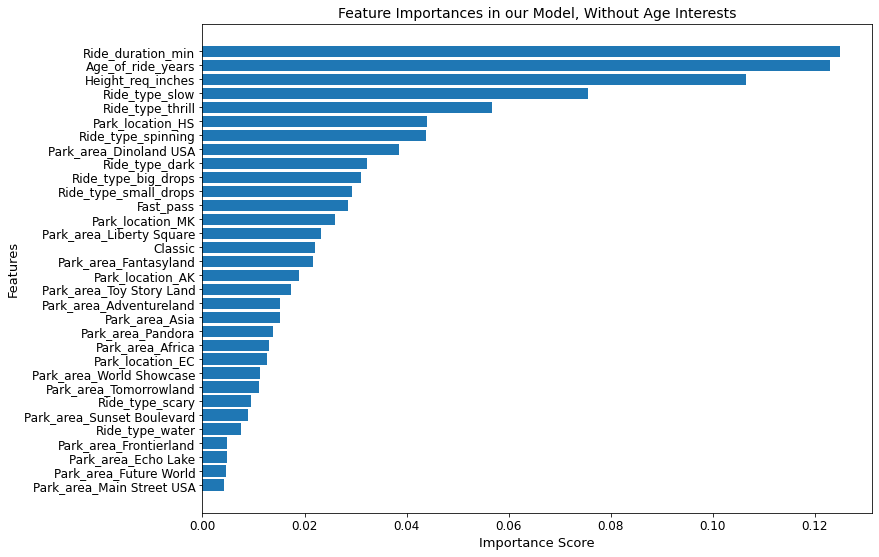

In [254]:
#what features affect our model the most?
rf_features = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (12, 9))
plt.barh(rf_features['feature'], rf_features['feature_importance'])
plt.xlabel('Importance Score', fontsize = 13)
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontsize = 13)
plt.yticks(fontsize = 12)
plt.title('Feature Importances in our Model, Without Age Interests', fontsize = 14);

# Standard DF

## ML Model

In [255]:
df['TA_Stars'].value_counts()

1    22
0    22
Name: TA_Stars, dtype: int64

In [256]:
X = df.drop(columns= 'TA_Stars')
y = df['TA_Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
#i also decided to use a 33% split rather than 25%

In [257]:
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts))) #splits are the same
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts))) 

Counts of each class in Training: {0: 14, 1: 15}
Counts of each class in Test: {0: 8, 1: 7}


In [258]:
#Baseline accuracy: the same as no_ages_df
print('Baseline Training Accuracy:')
print(y_train.value_counts(normalize=True)) 
print('---------------------------')
print('Baseline Testing Accuracy:')
print(y_test.value_counts(normalize=True)) 

Baseline Training Accuracy:
1    0.517241
0    0.482759
Name: TA_Stars, dtype: float64
---------------------------
Baseline Testing Accuracy:
0    0.533333
1    0.466667
Name: TA_Stars, dtype: float64


In [259]:
%%time
#running same things as before for comparison
rf = RandomForestClassifier(random_state=42)
rfpipe = make_pipeline(rf) 
rfpipe.fit(X_train, y_train)

knn = KNeighborsClassifier()
knnpipe = make_pipeline(StandardScaler(), knn)
knnpipe.fit(X_train, y_train)

xgb = make_pipeline(StandardScaler(), XGBClassifier())
xgb.fit(X_train, y_train)

lgb = make_pipeline(StandardScaler(), LGBMClassifier())
lgb.fit(X_train, y_train)

gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gbc.fit(X_train, y_train)

lr = LogisticRegression(random_state=42) 
lrpipe = make_pipeline(StandardScaler(), lr)
lrpipe.fit(X_train, y_train)


print('Random Forest Train Accuracy:', rfpipe.score(X_train, y_train))
print('Random ForestTest Accuracy:', rfpipe.score(X_test, y_test))
print('____________________________________')
print('KNN Train Accuracy:', knnpipe.score(X_train, y_train))
print('KNN Test Accuracy:', knnpipe.score(X_test, y_test))
print('____________________________________')
print('XGB Training accuracy:', xgb.score(X_train, y_train))
print('XGB Testing accuracy:', xgb.score(X_test, y_test))
print('____________________________________')
print('LGB Regression Train Accuracy:', lgb.score(X_train, y_train))
print('LGB Regression Test Accuracy:', lgb.score(X_test, y_test))
print('____________________________________')
print('GBC Regression Train Accuracy:', gbc.score(X_train, y_train))
print('GBC Regression Test Accuracy:', gbc.score(X_test, y_test))
print('____________________________________')
print('Logistic Regression Train Accuracy:', lrpipe.score(X_train, y_train))
print('Logistic Regression Test Accuracy:', lrpipe.score(X_test, y_test))

Random Forest Train Accuracy: 1.0
Random ForestTest Accuracy: 0.7333333333333333
____________________________________
KNN Train Accuracy: 0.6896551724137931
KNN Test Accuracy: 0.6666666666666666
____________________________________
XGB Training accuracy: 0.9310344827586207
XGB Testing accuracy: 0.7333333333333333
____________________________________
LGB Regression Train Accuracy: 0.5172413793103449
LGB Regression Test Accuracy: 0.4666666666666667
____________________________________
GBC Regression Train Accuracy: 1.0
GBC Regression Test Accuracy: 0.6666666666666666
____________________________________
Logistic Regression Train Accuracy: 0.9655172413793104
Logistic Regression Test Accuracy: 0.6666666666666666
CPU times: user 273 ms, sys: 12.1 ms, total: 285 ms
Wall time: 280 ms


Random Forest improves, the KNN training improves, the three boosting models stay the same, and the Logistic Regression improves on its training.

In [260]:
%%time
soft_vote = VotingClassifier(estimators = [('rf', rfpipe),('lr', lrpipe), ('xgb', xgb)],voting = 'soft')  #top three are XGB, rf, and lr
soft_vote.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, soft_vote.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, soft_vote.predict(X_test)))

Combined Models Training Accuracy: 0.9655172413793104
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 194 ms, sys: 7.09 ms, total: 201 ms
Wall time: 206 ms


The soft vote remains the same.

Classification Report For Soft Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



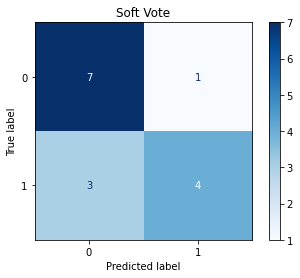

In [262]:
#classification report is same as other df soft vote
y_pred = soft_vote.predict(X_test)
print('Classification Report For Soft Vote')
print(metrics.classification_report(y_test, y_pred))
plot_confusion_matrix(soft_vote, X_test, y_test, cmap = 'Blues')
plt.title('Soft Vote');

In [192]:
#classification report for rf, same as the soft vote
y_pred = rfpipe.predict(X_test)
print('Classification Report for RF')
print(metrics.classification_report(y_test, y_pred))

Classification Report for RF
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



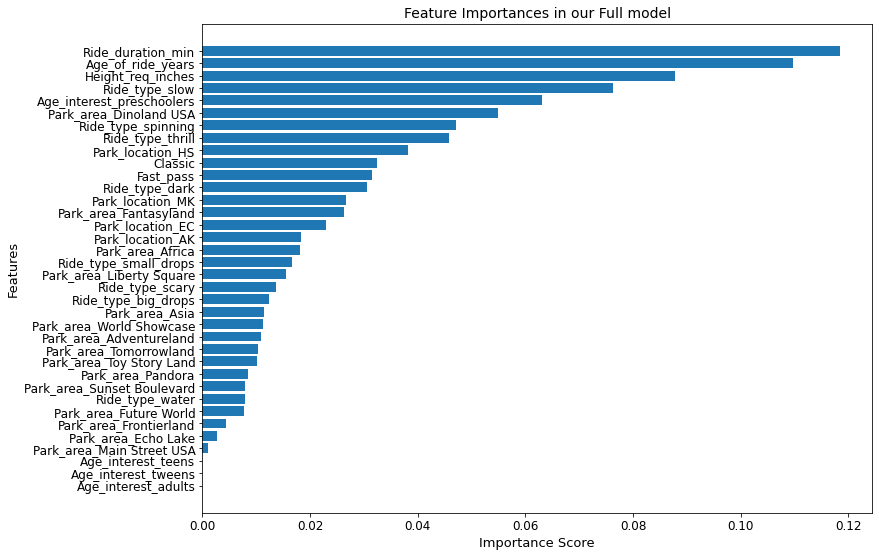

In [193]:
#looking again at the features applied to the model
rf_features = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (12, 9))
plt.barh(rf_features['feature'], rf_features['feature_importance'])
plt.xlabel('Importance Score', fontsize = 13)
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontsize = 13)
plt.yticks(fontsize = 12)
plt.title('Feature Importances in our Full model', fontsize = 14);
#looks similar to 

In [194]:
data = {'Feature': X.columns, 'Importance': rf.feature_importances_}
feature_importances = pd.DataFrame(data)
feature_importances

,Feature,Importance
0,Ride_type_thrill,0.045716
1,Ride_type_spinning,0.047173
2,Ride_type_slow,0.076324
3,Ride_type_small_drops,0.016624
4,Ride_type_big_drops,0.012314
5,Ride_type_dark,0.030654
6,Ride_type_scary,0.013683
7,Ride_type_water,0.007818
8,Fast_pass,0.031573
9,Classic,0.032456


In [195]:
ages_importances = feature_importances[(feature_importances['Feature'] == 'Age_interest_preschoolers') | (feature_importances['Feature'] =='Age_interest_tweens') | (feature_importances['Feature'] =='Age_interest_teens') | (feature_importances['Feature'] =='Age_interest_adults')]
ages_importances

,Feature,Importance
10,Age_interest_preschoolers,0.063085
11,Age_interest_tweens,0.000000
12,Age_interest_teens,0.000000
13,Age_interest_adults,0.000000


In [198]:
age_sum = ages_importances.sum()
print('Total of Importance Scores for Age Interests:',age_sum)
print('Percent of "Importance" that Age_interests have:', (0.063085*100))
print(feature_importances.shape)

Total of Importance Scores for Age Interests: Feature       Age_interest_preschoolersAge_interest_tweensAg...
Importance                                            0.0630851
dtype: object
Percent of "Importance" that Age_interests have: 6.3085
(36, 2)


# Which Model/Dataframe to further tune

The two data frames perform similarly; exactly the same on all models except KNN. Continuing on my look into the importance of the age_interest columns, I was able to see how much weight these columns had on our RF model.

The only age interest that has importance to the model is the preschoolers. That singular column, makes up about 6% of the importance values, when 1 column linearly would make up about 3% (1/36). It is double as important as we would expect with a baseline.

Going forward, I will choose to blend these dataframes and remove all the columns with zero importances (tweens, teens, and adults, keeping preschoolers).

## Combined Dataframe model

In [266]:
df2 = df.drop(columns=['Age_interest_tweens','Age_interest_teens','Age_interest_adults']) # remove the columns that have "zero importance"
df2.head()

,Ride_type_thrill,Ride_type_spinning,Ride_type_slow,Ride_type_small_drops,Ride_type_big_drops,Ride_type_dark,Ride_type_scary,Ride_type_water,Fast_pass,Classic,Age_interest_preschoolers,Height_req_inches,Ride_duration_min,Age_of_ride_years,TA_Stars,Park_location_AK,Park_location_EC,Park_location_HS,Park_location_MK,Park_area_Adventureland,Park_area_Africa,Park_area_Asia,Park_area_Dinoland USA,Park_area_Echo Lake,Park_area_Fantasyland,Park_area_Frontierland,Park_area_Future World,Park_area_Liberty Square,Park_area_Main Street USA,Park_area_Pandora,Park_area_Sunset Boulevard,Park_area_Tomorrowland,Park_area_Toy Story Land,Park_area_World Showcase
Ride_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alien Swirling Saucers,0,1,0,0,0,0,0,0,1,0,1,32,1.5,4.314168,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
Astro Orbiter,0,1,1,0,0,0,0,0,0,1,1,0,1.5,27.657084,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Avatar Flight of Passage,1,0,0,0,0,0,0,0,1,0,0,44,5.0,5.406571,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Big Thunder Mountain Railroad,1,0,0,1,0,0,0,0,1,1,0,40,3.5,42.080082,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Buzz Lightyear's Space Ranger Spin,0,1,1,0,0,0,0,0,1,0,1,0,4.0,24.043121,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [267]:
df2.shape

(44, 34)

In [268]:
#download into a csv
df2.to_csv('/content/drive/MyDrive/Coding Dojo/Project 2/WDW_Model_DF.csv')

In [269]:
X = df2.drop(columns= 'TA_Stars')
y = df2['TA_Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)
#i also decided to use a 33% split rather than 25%

In [270]:
unique, counts = np.unique(y_test, return_counts=True)
print('Counts of each class in Test:', dict(zip(unique, counts)))
unique, counts = np.unique(y_train, return_counts=True)
print('Counts of each class in Training:', dict(zip(unique, counts))) #splits are the same still

Counts of each class in Test: {0: 8, 1: 7}
Counts of each class in Training: {0: 14, 1: 15}


In [271]:
%%time
#running same things as before for comparison
rf = RandomForestClassifier(random_state=42)
rfpipe2 = make_pipeline(rf) 
rfpipe2.fit(X_train, y_train)

knn = KNeighborsClassifier()
knnpipe2 = make_pipeline(StandardScaler(), knn)
knnpipe2.fit(X_train, y_train)

xgb2 = make_pipeline(StandardScaler(), XGBClassifier())
xgb2.fit(X_train, y_train)

lgb2 = make_pipeline(StandardScaler(), LGBMClassifier())
lgb2.fit(X_train, y_train)

gbc2 = make_pipeline(StandardScaler(), GradientBoostingClassifier())
gbc2.fit(X_train, y_train)

lr = LogisticRegression(random_state=42) 
lrpipe2 = make_pipeline(StandardScaler(), lr)
lrpipe2.fit(X_train, y_train)


print('Random Forest Train Accuracy:', rfpipe2.score(X_train, y_train))
print('Random ForestTest Accuracy:', rfpipe2.score(X_test, y_test))
print('____________________________________')
print('KNN Train Accuracy:', knnpipe2.score(X_train, y_train))
print('KNN Test Accuracy:', knnpipe2.score(X_test, y_test))
print('____________________________________')
print('XGB Training accuracy:', xgb2.score(X_train, y_train))
print('XGB Testing accuracy:', xgb2.score(X_test, y_test))
print('____________________________________')
print('LGB Regression Train Accuracy:', lgb2.score(X_train, y_train))
print('LGB Regression Test Accuracy:', lgb2.score(X_test, y_test))
print('____________________________________')
print('GBC Regression Train Accuracy:', gbc2.score(X_train, y_train))
print('GBC Regression Test Accuracy:', gbc2.score(X_test, y_test))
print('____________________________________')
print('Logistic Regression Train Accuracy:', lrpipe2.score(X_train, y_train))
print('Logistic Regression Test Accuracy:', lrpipe2.score(X_test, y_test))

Random Forest Train Accuracy: 1.0
Random ForestTest Accuracy: 0.7333333333333333
____________________________________
KNN Train Accuracy: 0.6896551724137931
KNN Test Accuracy: 0.6666666666666666
____________________________________
XGB Training accuracy: 0.9310344827586207
XGB Testing accuracy: 0.7333333333333333
____________________________________
LGB Regression Train Accuracy: 0.5172413793103449
LGB Regression Test Accuracy: 0.4666666666666667
____________________________________
GBC Regression Train Accuracy: 1.0
GBC Regression Test Accuracy: 0.6666666666666666
____________________________________
Logistic Regression Train Accuracy: 0.9655172413793104
Logistic Regression Test Accuracy: 0.6666666666666666
CPU times: user 298 ms, sys: 8.07 ms, total: 306 ms
Wall time: 306 ms


Similar to the above but GBC is improved.

In [272]:
%%time
soft_vote2 = VotingClassifier(estimators = [('xgb', xgb2), ('gbc', gbc), ('lr', lrpipe2),('rf', rfpipe2)], voting = 'soft') #knn and lgb left out as they do not perform up to speed
soft_vote2.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, soft_vote2.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, soft_vote2.predict(X_test)))

Combined Models Training Accuracy: 1.0
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 251 ms, sys: 5.02 ms, total: 256 ms
Wall time: 255 ms


Training improves from before, testing is the same. Seems to match Random Forests.

In [273]:
#classification report
y_pred = soft_vote2.predict(X_test)
print('Classification Report For Soft Vote')
print(metrics.classification_report(y_test, y_pred))

Classification Report For Soft Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



In [274]:
#see if it matches RF
y_pred = rfpipe2.predict(X_test)
print('Classification Report for RF')
print(metrics.classification_report(y_test, y_pred))
#it is the same

Classification Report for RF
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



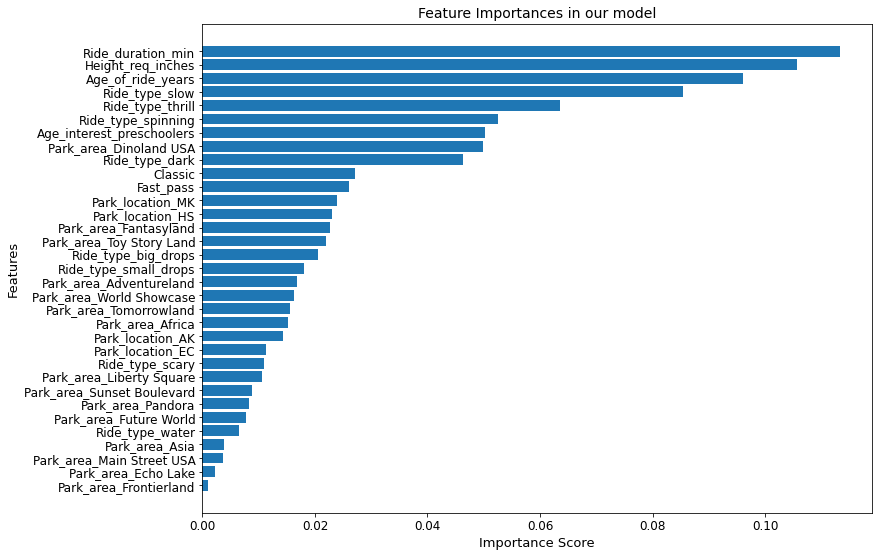

In [275]:
#new importances, all should be > 0 now
rf_features = pd.DataFrame({'feature': X_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize = (12, 9))
plt.barh(rf_features['feature'], rf_features['feature_importance'])
plt.xlabel('Importance Score', fontsize = 13)
plt.xticks(fontsize = 12)
plt.ylabel('Features', fontsize = 13)
plt.yticks(fontsize = 12)
plt.title('Feature Importances in our model', fontsize = 14);

# ML Tuning

The top two models were XGB and Random Forests, I will continue on with those models for hyperparameter tuning.

In [276]:
rfpipe2.get_params()

{'memory': None,
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impur

In [277]:
xgb2.get_params()

{'memory': None,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0,
                 learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                 nthread=None, objective='binary:logistic', random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                 silent=None, subsample=1, verbosity=1))],
 'verbose': False,
 'xgbclassifier': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate

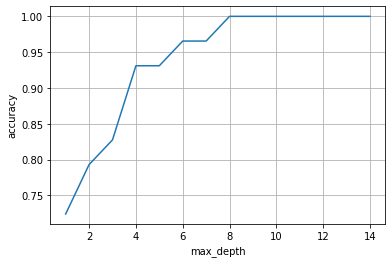

In [278]:
#list of values to try for max_depth:
max_depth_range = list(range(1,15)) 

#list to store the scores:
accuracy = []
for depth in max_depth_range:
  rf_depth = RandomForestClassifier(max_depth= depth,
                                   random_state = 42)
  rf_depth.fit(X_train, y_train)
  score = rf_depth.score(X_train, y_train)
  accuracy.append(score)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy)
plt.xlabel('max_depth')
plt.grid()
plt.ylabel('accuracy');
#anything above 8 depth is best accuracy!

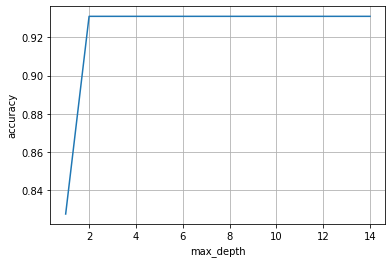

In [279]:
#list of values to try for max_depth:
max_depth_range = list(range(1,15)) 

#list to store the scores:
accuracy = []
for depth in max_depth_range:
  xgb_depth = XGBClassifier(max_depth= depth, 
                            random_state = 42)
  xgb_depth.fit(X_train, y_train)
  score = xgb_depth.score(X_train, y_train)
  accuracy.append(score)
import matplotlib.pyplot as plt
plt.plot(max_depth_range, accuracy)
plt.xlabel('max_depth')
plt.grid()
plt.ylabel('accuracy');
#anything above 2 depth is best accuracy!

In [280]:
%%time
xgb_params = {'xgbclassifier__max_depth': [2],
              'xgbclassifier__learning_rate': [0.3, 0.5, 1],
              'xgbclassifier__subsample': [0.5, 1]
              }
rf_params = {'randomforestclassifier__max_depth': [8],
             'randomforestclassifier__min_samples_split':[2, 5, 10, 15, 100],
             'randomforestclassifier__min_samples_leaf': [1, 2, 5, 10], 
             'randomforestclassifier__n_estimators': [100, 200, 300, 500]
             }

xgb_gs = GridSearchCV(xgb2, xgb_params)
rf_gs = GridSearchCV(rfpipe2, rf_params)

GridVote = VotingClassifier(estimators = [('rf', rf_gs), ('xgb', xgb_gs)], voting = 'soft')
GridVote.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, GridVote.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, GridVote.predict(X_test)))

Combined Models Training Accuracy: 0.9655172413793104
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 2min 29s, sys: 1.43 s, total: 2min 30s
Wall time: 2min 30s


Our first Gridsearch/Voting Classifier (GridVote) does not improve based on accuracy (same).

Classification Report For GridSearch Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15

Compared to the Pre-GridSearch (Soft Vote)
Classification Report For Soft Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



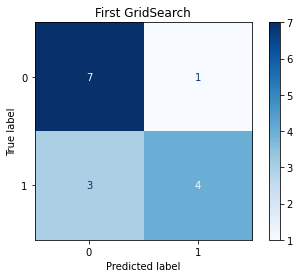

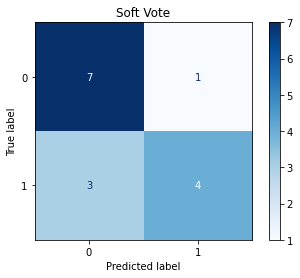

In [281]:
#confusion matrix with classification report to see
plot_confusion_matrix(GridVote, X_test, y_test, cmap = 'Blues')
plt.title('First GridSearch')
y_pred = GridVote.predict(X_test)
print('Classification Report For GridSearch Vote')
print(metrics.classification_report(y_test, y_pred))
print('Compared to the Pre-GridSearch (Soft Vote)')
plot_confusion_matrix(soft_vote2, X_test, y_test, cmap = 'Blues')
plt.title('Soft Vote')
y_pred = soft_vote2.predict(X_test)
print('Classification Report For Soft Vote')
print(metrics.classification_report(y_test, y_pred))

Our model struggles with the true positives, which has been consistent with the datasets.

In [282]:
#I wanted to look at them individually
xgb_gs.fit(X_train, y_train)
print('XGB Training Accuracy:', accuracy_score(y_train, xgb_gs.predict(X_train)))
print('XGB Testing Accuracy:', accuracy_score(y_test, xgb_gs.predict(X_test)))
print(xgb_gs.best_params_)
print('______________________________________')
rf_gs.fit(X_train, y_train)
print('Random Forests Training Accuracy:', accuracy_score(y_train, rf_gs.predict(X_train)))
print('Random Forests Testing Accuracy:', accuracy_score(y_test, rf_gs.predict(X_test)))
print(rf_gs.best_params_)
print('______________________________________')

XGB Training Accuracy: 0.9655172413793104
XGB Testing Accuracy: 0.7333333333333333
{'xgbclassifier__learning_rate': 0.5, 'xgbclassifier__max_depth': 2, 'xgbclassifier__subsample': 1}
______________________________________
Random Forests Training Accuracy: 0.7241379310344828
Random Forests Testing Accuracy: 0.7333333333333333
{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
______________________________________


* XGB improved its training slightly with GridSearch
* Random Forests' Training becomes less overfit (closer to its testing accuracy), but with no improvement to its testing accuracy.

In [283]:
%%time
#trying more parameters around the good ones above
xgb2_params = {'xgbclassifier__max_depth': [2],
              'xgbclassifier__learning_rate': [0.3, 0.5, 0.7],
              'xgbclassifier__subsample': [0.5, 1]
              }
rf2_params = {'randomforestclassifier__max_depth': [8],
             'randomforestclassifier__min_samples_split':[0.9, 2, 3],
             'randomforestclassifier__min_samples_leaf': [3, 5, 7], 
             'randomforestclassifier__n_estimators': [50, 75, 90, 100, 120, 150]
             }

xgb2_gs = GridSearchCV(xgb2, xgb2_params)
rf2_gs = GridSearchCV(rfpipe2, rf2_params)

GridVote2 = VotingClassifier(estimators = [('rf', rf2_gs), ('xgb', xgb2_gs)], voting = 'soft')
GridVote2.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, GridVote2.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, GridVote2.predict(X_test)))

Combined Models Training Accuracy: 0.9655172413793104
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 37.3 s, sys: 353 ms, total: 37.6 s
Wall time: 37.4 s


No changes.

In [284]:
xgb2_gs.fit(X_train, y_train)
print('XGB Training Accuracy:', accuracy_score(y_train, xgb2_gs.predict(X_train)))
print('XGB Testing Accuracy:', accuracy_score(y_test, xgb2_gs.predict(X_test)))
print(xgb2_gs.best_params_)
print('______________________________________')
rf2_gs.fit(X_train, y_train)
print('Random Forests Training Accuracy:', accuracy_score(y_train, rf2_gs.predict(X_train)))
print('Random Forests Testing Accuracy:', accuracy_score(y_test, rf2_gs.predict(X_test)))
print(rf2_gs.best_params_)
print('______________________________________')

XGB Training Accuracy: 0.9655172413793104
XGB Testing Accuracy: 0.7333333333333333
{'xgbclassifier__learning_rate': 0.5, 'xgbclassifier__max_depth': 2, 'xgbclassifier__subsample': 1}
______________________________________
Random Forests Training Accuracy: 0.7241379310344828
Random Forests Testing Accuracy: 0.7333333333333333
{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50}
______________________________________


XGB was the chosen model for the soft vote in this round. Neither model improved. The XGB did not change any of its hyperparameters when it was given more options so it is optimized.

In [285]:
#one more try to improve Random Forests
%%time
xgb3_params = {'xgbclassifier__max_depth': [2],
              'xgbclassifier__learning_rate': [0.5],
              'xgbclassifier__subsample': [1]
              }
rf3_params = {'randomforestclassifier__max_depth': [8],
             'randomforestclassifier__min_samples_split':[2, 3],
             'randomforestclassifier__min_samples_leaf': [1, 3, 4], 
             'randomforestclassifier__n_estimators': [30, 40, 50, 64] #64 because its max_depth ^2
             }

xgb3_gs = GridSearchCV(xgb2, xgb3_params)
rf3_gs = GridSearchCV(rfpipe2, rf3_params)

GridVote3 = VotingClassifier(estimators = [('rf', rf3_gs), ('xgb', xgb3_gs)], voting = 'soft')
GridVote3.fit(X_train, y_train)
print('Combined Models Training Accuracy:', accuracy_score(y_train, GridVote3.predict(X_train)))
print('Combined Models Testing Accuracy:', accuracy_score(y_test, GridVote3.predict(X_test)))

Combined Models Training Accuracy: 0.9655172413793104
Combined Models Testing Accuracy: 0.7333333333333333
CPU times: user 8.22 s, sys: 70.2 ms, total: 8.29 s
Wall time: 8.26 s


Yet again no changes. What did Random Forests do?

In [286]:
rf3_gs.fit(X_train, y_train)
print('Random Forests Training Accuracy:', accuracy_score(y_train, rf3_gs.predict(X_train)))
print('Random Forests Testing Accuracy:', accuracy_score(y_test, rf3_gs.predict(X_test)))
print(rf3_gs.best_params_)
print('______________________________________')

Random Forests Training Accuracy: 0.7241379310344828
Random Forests Testing Accuracy: 0.7333333333333333
{'randomforestclassifier__max_depth': 8, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 40}
______________________________________


Parameters have changed a little, but it seems that Random Forests is optimized as much as it will be able to. The training performs less accurately than the testing data.

# Evaluations

Classification Report For First GridSearch Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15

Compared to the Last GridSearch
Classification Report For Last Gridvote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15

Compared to the Pre-GridSearch (Soft Vote)
Classification Report For Soft Vote
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57     

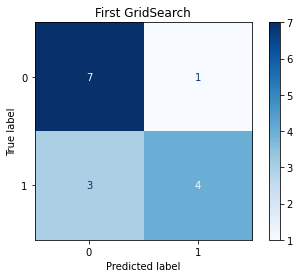

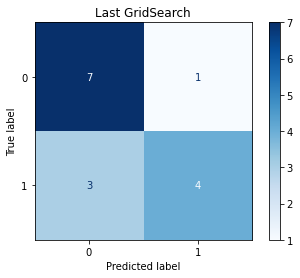

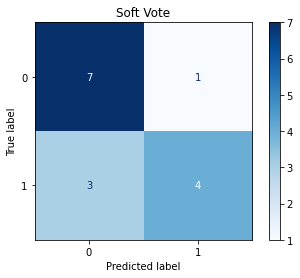

In [287]:
#confusion matrix with classification report to see all for this model
plot_confusion_matrix(GridVote, X_test, y_test, cmap = 'Blues')
plt.title('First GridSearch')
y_pred = GridVote.predict(X_test)
print('Classification Report For First GridSearch Vote')
print(metrics.classification_report(y_test, y_pred))
print('Compared to the Last GridSearch')
plot_confusion_matrix(GridVote3, X_test, y_test, cmap = 'Blues')
plt.title('Last GridSearch')
y_pred = GridVote3.predict(X_test)
print('Classification Report For Last Gridvote')
print(metrics.classification_report(y_test, y_pred))
print('Compared to the Pre-GridSearch (Soft Vote)')
plot_confusion_matrix(soft_vote2, X_test, y_test, cmap = 'Blues')
plt.title('Soft Vote')
y_pred = soft_vote2.predict(X_test)
print('Classification Report For Soft Vote')
print(metrics.classification_report(y_test, y_pred))

It did not improve from any of our Gridsearches.

Classification Report For Best XGB
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.80      0.57      0.67         7

    accuracy                           0.73        15
   macro avg       0.75      0.72      0.72        15
weighted avg       0.75      0.73      0.73        15



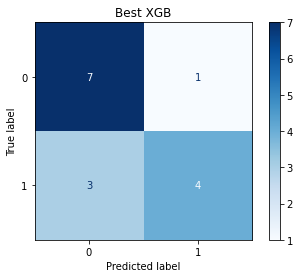

In [291]:
plot_confusion_matrix(xgb2_gs, X_test, y_test, cmap = 'Blues')
plt.title('Best XGB')
y_pred = xgb2_gs.predict(X_test)
print('Classification Report For Best XGB')
print(metrics.classification_report(y_test, y_pred))

The above is identical to our Gridsearches and Soft Vote.
Therefore, XGB is our most preferred model for this machine learning problem.